In [1]:
import sys
sys.path.append(r'D:\github\ripple_heterogeneity\python')
import functions,loading

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import importlib
import glob
import os
import pickle
import replay_fig
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
import random
import itertools
from scipy import stats


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [10]:
# df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
# df.basepath.unique()

In [2]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
df = df[df.basepath.str.contains('GrosmarkAD')]
df
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay_test'
# replay_run.main(df,save_path,parallel=True)

,Var1,basepath,basename
97,97,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,Achilles_10252013
98,98,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013,Achilles_11012013
99,99,Z:\Data\GrosmarkAD\Buddy\Buddy_06272013,Buddy_06272013
100,100,Z:\Data\GrosmarkAD\Cicero\Cicero_09012014,Cicero_09012014
101,101,Z:\Data\GrosmarkAD\Cicero\Cicero_09102014,Cicero_09102014
102,102,Z:\Data\GrosmarkAD\Cicero\Cicero_09172014,Cicero_09172014
103,103,Z:\Data\GrosmarkAD\Gatsby\Gatsby_08022013,Gatsby_08022013
104,104,Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013,Gatsby_08282013


In [17]:
def pairwise_corr(unit_mat):
    x = np.arange(0,unit_mat.shape[0])
    c = np.array(list(itertools.combinations(x, 2)))
    rho = []
    pval = []
    for i,s in enumerate(c):	
        rho_, pval_ = stats.spearmanr(unit_mat[s[0],:], unit_mat[s[1],:])
        rho.append(rho_)
        pval.append(pval_)
    return rho,pval,c

importlib.reload(functions)
basepath = df.basepath.unique()[0]

cell_metrics,data,ripples,fs_dat = loading.load_basic_data(basepath)

restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")) &
                    (cell_metrics.bad_unit == False))  
                    
# restrict cell metrics                      
cell_metrics = cell_metrics[restrict_idx]

st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)
ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
st_unit_rip = st_unit[ripple_epochs]

spk_count_rip = functions.get_participation(st_unit.data,ripples.start.values,ripples.stop.values,par_type='counts')

rho,pval,c = pairwise_corr(spk_count_rip)

temp_df = pd.DataFrame()
temp_df['ref'] = c[:,0]
temp_df['target'] = c[:,1]
temp_df['UID_ref'] = cell_metrics.UID.iloc[temp_df['ref']].values
temp_df['UID_target'] = cell_metrics.UID.iloc[temp_df['target']].values
temp_df['rho'] = rho
temp_df['pval'] = pval
temp_df['deepSuperficial_ref'] = cell_metrics.deepSuperficial.iloc[temp_df['ref']].values
temp_df['deepSuperficial_target'] = cell_metrics.deepSuperficial.iloc[temp_df['target']].values
temp_df['basepath'] = basepath

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [13]:
temp_df

,ref,target,UID_ref,UID_target,rho,pval,deepSuperficial_ref,deepSuperficial_target,basepath
0,0,1,1,3,0.029471,1.755862e-03,Deep,Superficial,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
1,0,2,1,4,0.028926,2.134949e-03,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
2,0,3,1,5,-0.001878,8.419785e-01,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
3,0,4,1,7,-0.003942,6.756905e-01,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
4,0,5,1,9,-0.030480,1.212511e-03,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
...,...,...,...,...,...,...,...,...,...
28915,237,239,272,274,0.022569,1.658589e-02,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
28916,237,240,272,275,0.029005,2.075299e-03,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
28917,238,239,273,274,0.150396,5.333362e-58,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
28918,238,240,273,275,0.004501,6.328206e-01,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013


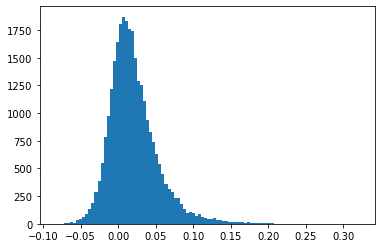

In [16]:
plt.hist(temp_df.rho,100)
plt.show()

In [25]:
def SVCA_v2(Ff, npc, ntrain, ntest, itrain, itest):
    """
    computes a cross-validated form of PCA: Shared Variance Component
    Analysis. Components are extracted from the covariance between neuron
    sets "ntrain" and "ntest" on training timepts "itrain". The variance of
    these covariance components is computed on testing timepts "itest". 
    This variance is the amount of reliable variance of that component 
    (because it's consistent across timepts). 
    Why compute it in the covariance space?
    we assume the covariance btw/ neurons is consistent across time 
    - we have no other metric to track because we are not presenting stimuli
    INPUTS:
        Ff (neurons x timepts)
        npc (number of PCs to compute)
        ntrain (one half of neurons)
        ntest (other half of neurons)
        itrain (one half of timepts)
        itest (other half of timepts)
    OUTPUTS:
        sneur (shared variance of each covariance component)
        vneur (total variance of each covariance component)
        u (left eigenvectors of covariance matrix btw ntrain and ntest on
        itrain timepts)
        v (right eigenvectors of covariance matrix btw ntrain and ntest on
        itrain timepts)

    From stringer-pachitariu-et-al-2018a
    https://github.com/MouseLand/stringer-pachitariu-et-al-2018a
    """
    cov = Ff[ntrain,itrain] * Ff[ntest,itrain].T
    u,s,v = np.linalg.svd(cov,full_matrices=False)
    u = u[:,0:npc]
    v = v[:,0:npc]
    s1 = u.T * Ff[ntrain,itest]
    s2 = v.T * Ff[ntest,itest]
    sneur = np.sum(s1 * s2, axis=1)
    varneur = np.sum(s1**2 + s2**2,axis=1) / 2
    return sneur, varneur, u, v

In [71]:
from sklearn.decomposition import PCA

def SVCA(X):
    """
    computes a cross-validated form of PCA: Shared Variance Component
    Analysis. Components are extracted from the covariance between neuron
    sets "ntrain" and "ntest" on training timepts "itrain". The variance of
    these covariance components is computed on testing timepts "itest". 
    This variance is the amount of reliable variance of that component 
    (because it's consistent across timepts).
    Inputs:
        X: (neurons x timepts)
    Outputs:
        scov (shared variance of each covariance component)
        varcov (total variance of each covariance component)
    """
    
    NN,NT = X.shape

    # split cells into test and train
    norder = np.random.permutation(NN)
    nhalf = int(norder.size/2)
    ntrain = norder[:nhalf]
    ntest = norder[nhalf:]

    # split time into test and train
    torder = np.random.permutation(NT)
    thalf = int(torder.size/2)
    ttrain = torder[:thalf]
    ttest = torder[thalf:]

    cov = X[np.ix_(ntrain, ttrain)] @ X[np.ix_(ntest, ttrain)].T
    u = PCA(n_components=min(1024, nhalf-1), svd_solver='randomized').fit_transform(cov)
    u /= (u**2).sum(axis=0)**0.5
    v = cov.T @ u
    v /= (v**2).sum(axis=0)**0.5

    strain = u.T @ X[np.ix_(ntrain,ttest)]
    stest = v.T @ X[np.ix_(ntest,ttest)]

    # covariance k is uk.T * F * G.T * vk / npts
    scov = (strain * stest).mean(axis=1)
    varcov = (strain**2 + stest**2).mean(axis=1) / 2

    return scov, varcov,strain,stest

In [34]:
importlib.reload(functions)

<module 'functions' from 'D:\\github\\ripple_heterogeneity\\python\\functions.py'>

In [69]:
basepath = df.basepath.unique()[0]

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
cell_metrics,data,ripples,fs_dat = loading.load_basic_data(basepath)

restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")) &
                    (cell_metrics.bad_unit == False))  
                    
# restrict cell metrics                      
cell_metrics = cell_metrics[restrict_idx]

st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)
ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])

unit_mat = functions.get_participation(st_unit.data,ripples.start,ripples.stop,par_type='firing_rate')
unit_mat = nel.AnalogSignalArray(data=unit_mat,timestamps=ripples.peaks,support=ripple_epochs)

epoch_df = loading.load_epoch(basepath)
beh_epochs = nel.EpochArray([np.array([epoch_df.startTime,epoch_df.stopTime]).T])


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:236: UserWarning: fs was not specified, so we try to estimate it from the data...
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:238: UserWarning: fs was estimated to be 0.7961783439494228 Hz
D:\github\ripple_heterogeneity\python\loading.py:587: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


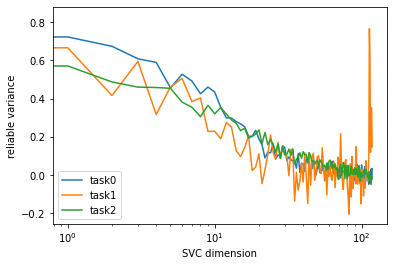

In [72]:
plt.figure()

for i,ep in enumerate(beh_epochs):
    scov, varcov,strain,stest = SVCA(unit_mat[ep].data)
    plt.plot(scov/varcov,label='task'+str(i))

plt.xscale('log')
plt.xlabel('SVC dimension')
plt.ylabel('reliable variance')
plt.legend()

In [83]:
strain.shape

(119, 2957)

(-20.32694010932726, 27.805234695043247, -32.4549387280101, 15.581216939803397)

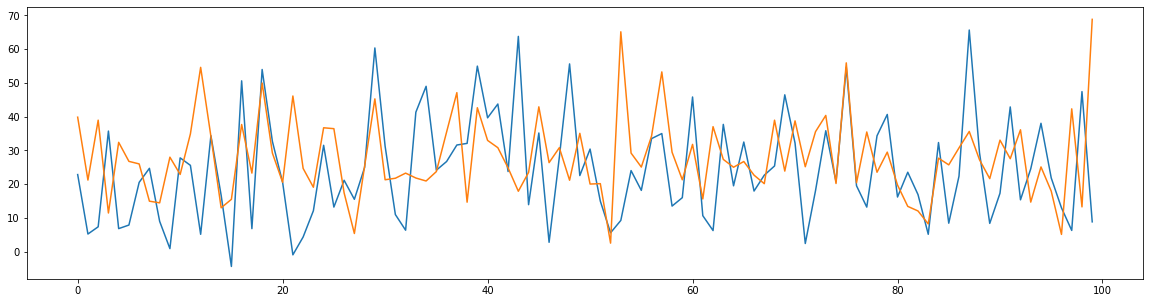

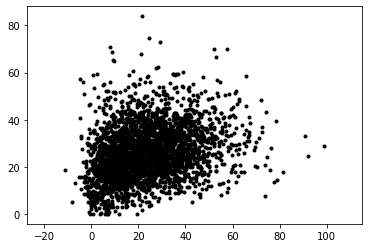

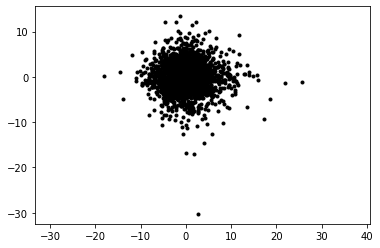

In [85]:


plt.figure(figsize=(20,5))
plt.plot(strain[0,0:100])
plt.plot(stest[0,0:100])

plt.figure()
plt.plot(strain[0,:],stest[0,:],'.k')
plt.axis('equal')

plt.figure()
plt.plot(strain[118,:],stest[118,:],'.k')
plt.axis('equal')

<AxesSubplot:>

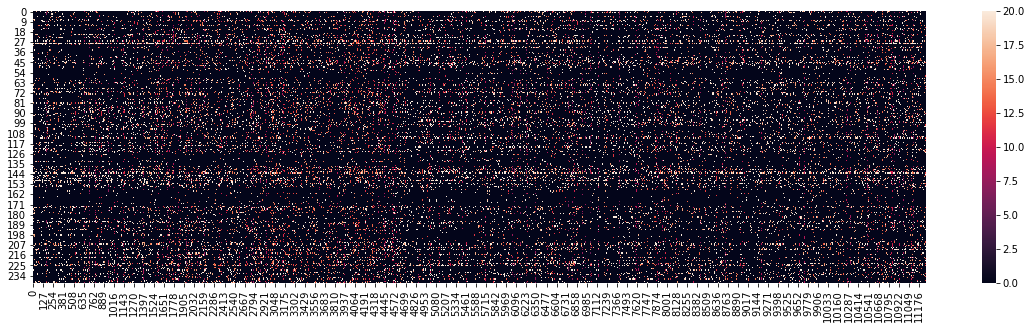

In [42]:
plt.figure(figsize=(20,5))
sns.heatmap(unit_mat,vmax=20)

Text(0, 0.5, 'reliable variance')

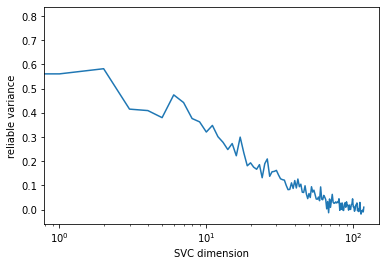

In [55]:
plt.figure()
plt.plot(scov/varcov)
plt.xscale('log')
plt.xlabel('SVC dimension')
plt.ylabel('reliable variance')



In [ ]:
X = unit_mat
NN,NT = X.shape

# split cells into test and train
norder = np.random.permutation(NN)

ntrain1 = ntrain(randperm(len(ntrain), nneur1(n)))
ntest1 = ntest(randperm(len(ntest), nneur1(n)))

sneur, varneur, u, v = SVCA(Ff, min(npc, nneur1(n)), ntrain1, ntest1,	itrain, itest)